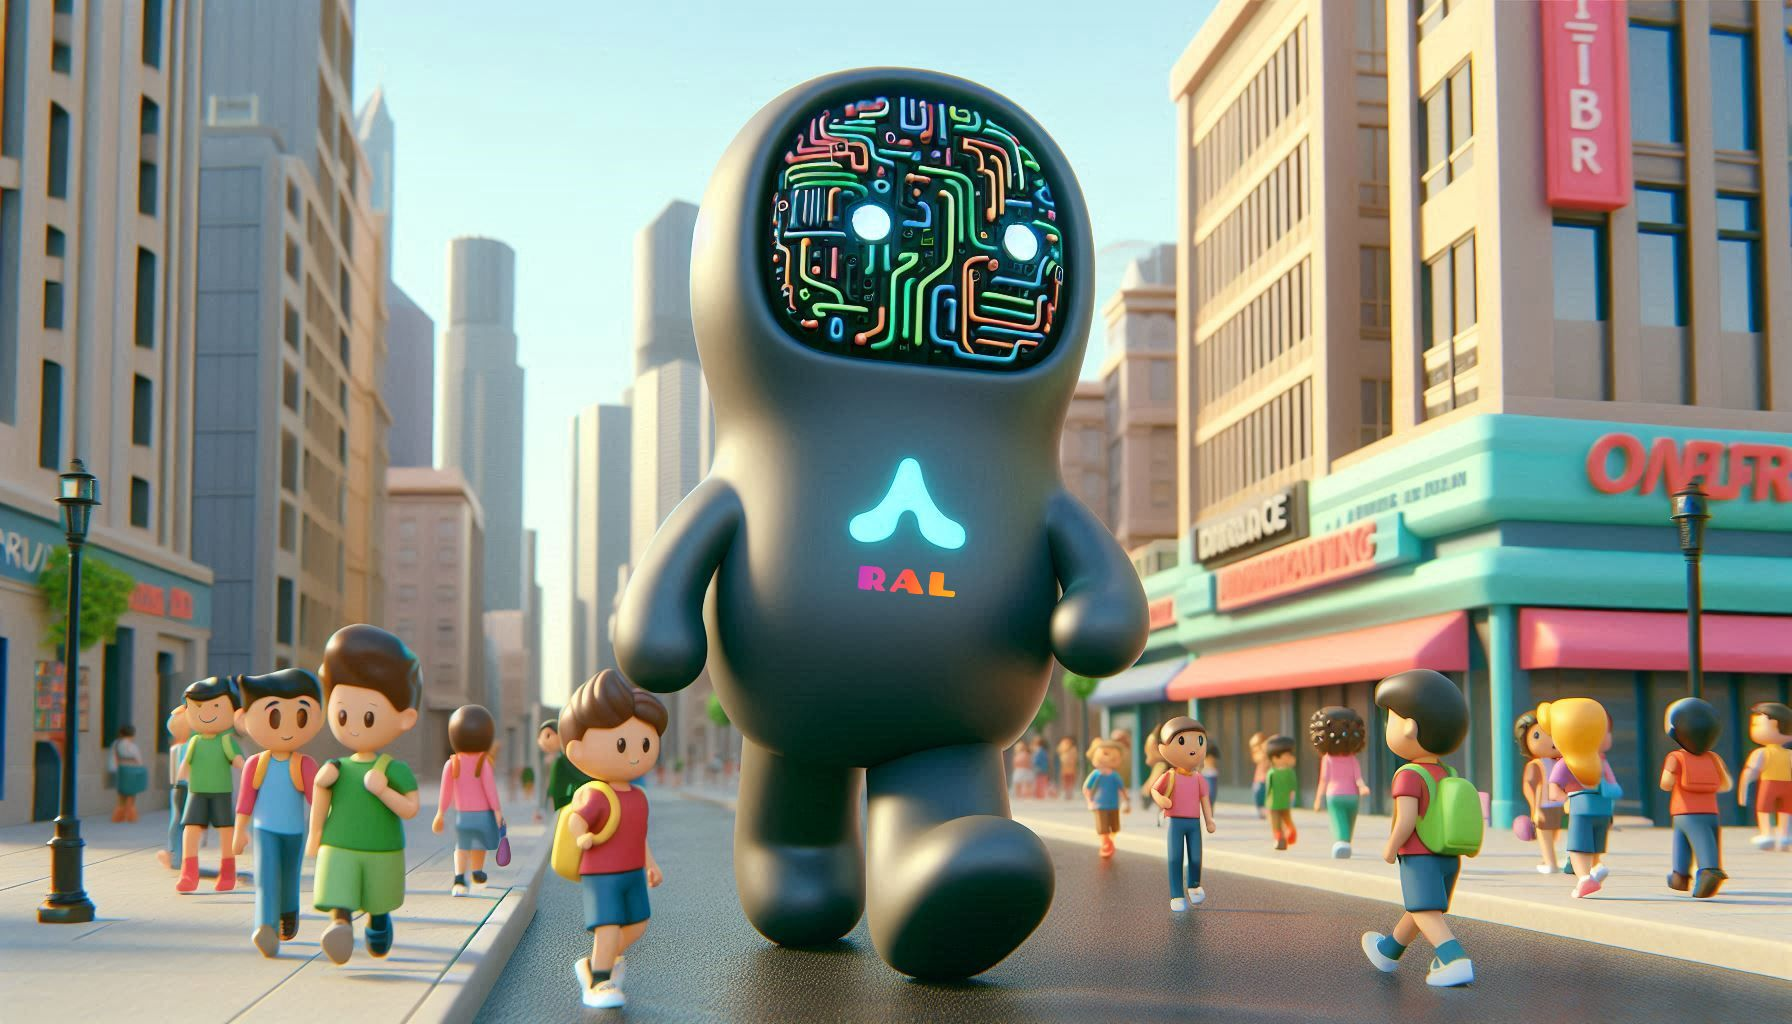

---
# **RAL - Implementing a DQN  - The Lunar Lander game**
---

## **Section 0 - Problem introduction**


The **Lunar Lander environment** is a popular benchmark in reinforcement learning, designed to **simulate the task of landing a lunar module on the surface of the moon**. 🚀🥮

The **lander is our agent**, and must **use its thrusters to control position and orientation**, aiming to **land on a designated spot without crashing**. 💥

The **simulation is the environment**, providing moon-like physics, a landing surface, rules, possible interactions, and feedback (rewards) based on the lander's actions. 🔢

The **goal is to safely land the module as close to the landing pad as possible**, while avoiding rough landings or using excessive fuel. 🏅

This [environment is available on Gymnasium](https://gymnasium.farama.org/environments/box2d/lunar_lander/), a platform providing APIs for popular RL environments like this one, which we'll be using in this exercise.

<br>

![LunarLanderGIF](https://gymnasium.farama.org/_images/lunar_lander.gif)

### **State and Action Space**

In this mission, our agent (the lander) has some important **state information** to guide its decisions:
  - **X and Y coordinates** - where it is, relatively to the landing pad 🧭
  - **X and Y velocities** - how fast it's moving 💨
  - **Angle and angular velocity** - is it upright or tumbling through space? 🚀🤸
  - **Left and right leg contact** - are we touching down or still floating? 👢👢

And for **actions**, the lander has four options:
  - **Do nothing** and drift 🍂
  - **Fire the left orientation engine** 🔃
  - **Fire the main engine** 🔥 (bye bye, gravity!)
  - **Fire the right orientation engine** 🔄

### **Rewards and Goals**

The lander's goal is clear: **land safely on the designated pad**. For every decision, it earns:
  - Points for **getting closer to the pad** 💡
  - Points for **safe, slow and steady travel** 🦺
  - Big points for a **safe landing** 🎉
  - Penalties for **wasting fuel**, **going fast** or **crashing**! 😬

You can find more details about the rewards on the [dedicated environment section](https://gymnasium.farama.org/environments/box2d/lunar_lander/#rewards) on Gymnasium.

An episode (or mission) ends with either a successful touchdown or a crash, which makes this environment a perfect testbed for **Deep Q Networks (DQN)**!

### **Why the Lunar Lander?**

This classic setup helps us explore key RL concepts like **exploration vs. exploitation** and understand how DQNs handle real-world-inspired tasks with tricky dynamics (gravity, rotation): all in the safety of simulated space! 🌌

## **Section 1 - Notebook setting**

### Step 1.1: Set up a GPU in Google Colab

To **speed up training**, we should enable the GPU support in Colab. ⚡

Here's how:
1. Click on `Runtime` at the top of the Colab window.
2. Select `Change runtime type` from the dropdown menu.
3. In the dialog box, choose a `T4 GPU` as hardware accelerator.
4. Click `Save` to confirm.

### Step 1.2: Install and import the required packages

We need to prepare our notebook to make use of the required libraries, so let's install all the necessary dependencies! 🔧

In particular, we'll need:
- **PyTorch (`torch`, `torch.nn`, `torch.optim`)**: to build and train our neural network model.
- **Random, NumPy, and Collections** (`namedtuple`, `deque`): for managing randomness, arrays, and replay memory during the agent's exploration process.
- **Gymnasium (`gym`)**: providing the Lunar Lander environment where our agent will learn to land safely.
- **TQDM**: a progress bar to help us track training.
- **Matplotlib**: for plotting rewards to track agent performance.
- **Image and GIF utilities**:
  - `PIL` (for overlaying the score on each frame),
  - `imageio` (for saving frames as GIFs),
  - `IPython.display` (for displaying GIFs directly in the notebook).
- **OS and Time**: `os` (for file and directory management) and `sleep` (for display pauses).


In [34]:
""" %pip install swig
%pip install torch gymnasium matplotlib tqdm imageio
%conda install -c conda-forge gymnasium-box2d """

' %pip install swig\n%pip install torch gymnasium matplotlib tqdm imageio\n%conda install -c conda-forge gymnasium-box2d '

In [35]:
# Standard
from collections import namedtuple, deque
import imageio
from IPython.display import Image as IPImage
import os
from PIL import Image, ImageDraw, ImageFont
import random
from time import sleep

# Third-party
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import trange

### Step 1.3: Define the computational device

Finally, we'll define the **hardware** that *PyTorch* will use for computations, storing this information in the `device` variable.

In [36]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


After running the cell, **you should see *Using device: cuda:0* if the GPU is set up correctly**. If it printed *cpu*, you might need to double-check your GPU setup. Go back to step 1.1 to ensure that GPU is enabled in Colab. 🛠

## **Section 2 - Designing the Deep Q Network**

### Step 2.1: Policy Network (QNet)

We're starting by defining the **Policy Network** to estimate the Q-values of each action from the current state. As discussed in our lectures, a Q-value represents the **expected cumulative reward** for taking an action in a specific state. 🏅

This network will take the **state of the environment** as input, and output **Q-values for each possible action**.

**Use the `QNet` class to define this neural network**, which will be essential for our DQN agent. Here's what you'll need to include:
- **Input layer** that maps **from the state vector** (continuous values for lander *position*, *speed*, ...) **to the hidden layer**,
- **1 hidden layer** with a dimensionality of 64,
- **RELU activation** functions for the input and hidden layers,
- A **final output layer** that maps **from the 64-dimensional hidden layer to the number of actions** our agent can take.

You can find the required layers and activation functions in the `nn` module of `torch`.

P.S. The final **output layer is a regression layer** that outputs the Q-values for each action.

P.P.S. If you are having too much of a hard time completing the TODO, you can check out the [solution here](https://www.youtube.com/watch?v=xvFZjo5PgG0).

In [37]:
class QNet(nn.Module):
    # Policy Network
    def __init__(self, n_state_vars, n_actions, dim_hidden=64):
        super(QNet, self).__init__()

        # Define a feedforward neural network with hidden layers, ReLU
        #  activations, and an output layer that maps to the number of actions
        self.fc = nn.Sequential(
            nn.Linear(n_state_vars, dim_hidden),
            nn.ReLU(),
            nn.Linear(dim_hidden, dim_hidden),
            nn.ReLU(),
            nn.Linear(dim_hidden, n_actions),
        )

    def forward(self, x):
        # Passes the input through the network layers to output Q-values
        return self.fc(x)

### Step 2.2: Replay buffer for Experience Replay

The `ReplayBuffer` class implements the **Experience Replay**. 🔁

With this technique we **store past experiences** (*state*, *action*, *reward*, *next state*, *done*) in memory, allowing us to **sample and reuse them during training**. As we said in the lectures, this reduces correlations in training data, improving stability and efficiency.

To implement this buffer and manage memory efficiently, we suggest Python's `deque` (double-ended queue). The `deque` is a great choice because it allows us to:
- **Add new experiences** quickly (`append()`),
- Remove old experiences automatically when we reach the memory limit.

You should **initialize `deque` with a fixed `maxlen`** (for now we use a generic `memory_size` parameter), so when it exceeds this limit, it automatically discards the oldest experience to make space for new ones.

Also remember that, when using this memory for training, you should **randomly extract a sample of past experiences**, of whose extraction you can take care of using the `random` module.


In [38]:
class ReplayBuffer:
    def __init__(self, n_actions, memory_size, batch_size):
        # Initialize actions, batch and experience template
        self.n_actions = n_actions
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        # Initialize the memory
        self.memory = deque(maxlen=memory_size) # Hint: use deque

    def __len__(self):
        return len(self.memory)

    def add(self, state, action, reward, next_state, done):
        # Store experience in memory
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        # Sample a batch of experiences
        experiences = random.sample(self.memory, self.batch_size)  # Hint: use random

        # Convert to tensors for training
        states = torch.from_numpy(
            np.vstack([e.state for e in experiences if e is not None])
        ).float().to(device)

        actions = torch.from_numpy(
            np.vstack([e.action for e in experiences if e is not None])
        ).long().to(device)

        rewards = torch.from_numpy(
            np.vstack([e.reward for e in experiences if e is not None])
        ).float().to(device)

        next_states = torch.from_numpy(
            np.vstack([e.next_state for e in experiences if e is not None])
        ).float().to(device)

        dones = torch.from_numpy(
            np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)
        ).float().to(device)

        # Return the tuple with all tensors (we use the brackets to create a tuple)
        return (states, actions, rewards, next_states, dones)

### Step 2.3: The DQN Agent

Next, we define the **DQN Agent** using the `DQN` class. 👾

This class defines **how our agent interacts with the environment**, **learns from experiences** (`learn()`), and **improves its policy** over time.

This class is the core of our agent and handles the following key tasks:
- **Selecting actions** (`getAction()`) using an epsilon-greedy strategy based on the Q-values generated by our previously defined `QNet`.
- **Storing experiences** (`save2Memory()`) in memory by using the custom `ReplayBuffer`.
- **Learning** (`learn()`) by updating the policy network to minimize the difference between predicted and target Q-values.
- **Updating the target network** (`targetUpdate()`) to stabilize training.



In [39]:
class DQN:
    def __init__(
        self, n_states, n_actions, batch_size=64, learning_rate=1e-4,
        learn_step=5, gamma=0.99, mem_size=int(1e5), tau=1e-3
    ):
        # Core parameters for learning and updating the Q-network
        self.n_states = n_states
        self.n_actions = n_actions
        self.batch_size = batch_size
        self.gamma = gamma  # Discount factor for future rewards
        self.learn_step = learn_step  # Frequency of learning steps
        self.tau = tau  # Rate for soft updating the target network

        # Initialize the policy network (net_eval) and target network (net_target)
        self.net_eval = QNet(n_states, n_actions).to(device)  # Hint: we have a class for this
        self.net_target = QNet(n_states, n_actions).to(device)  # Hint: we have a class for this
        self.optimizer = optim.Adam(self.net_eval.parameters(), lr=learning_rate)  # Suggestion: use Adam from `optim` with specific learning rate and parameters of the net_eval network
        self.criterion = nn.MSELoss()  # Suggestion: use Mean Squared Error (MSE) as the loss function

        # Initialize memory for experience replay
        self.memory = ReplayBuffer(n_actions, mem_size, batch_size)  # Hint: we have a class for this
        self.counter = 0  # Tracks learning steps for periodic updates

    def getAction(self, state, epsilon):
        # Select action using an epsilon-greedy strategy to balance exploration
        #  and exploitation
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)

        self.net_eval.eval()  # Set network to evaluation mode
        with torch.no_grad():
            action_values = self.net_eval(state)
        self.net_eval.train()  # Return to training mode

        # Choose random action with probability epsilon, otherwise choose best
        #  predicted action
        # Generiamo un numero R
        if random.random() < epsilon: # random.random rende un numero tra 0 e 1
          action = random.choice(np.arange(self.n_actions)) # scelgo casualmente l'azione da fare
        else:
          action = np.argmax(action_values.cpu().data.numpy()) # Hint: you may find `np.argmax` useful
        return action

    def save2Memory(self, state, action, reward, next_state, done):
        # Save experience to memory and, if ready, sample from memory and
        #  update the network
        self.memory.add(state, action, reward, next_state, done)
        self.counter += 1  # Increment step counter

        # Perform learning every 'learn_step' steps if enough experiences are
        #  in memory
        if (self.counter % self.learn_step == 0 and len(self.memory) >= self.batch_size):  # Hint: check if counter is a multiple of learn_step and
                  #  memory has enough samples
            experiences = self.memory.sample()  # Hint: retrieve a sample of experiences
            self.learn(experiences)

    def learn(self, experiences):
        # Perform a learning step by minimizing the difference between
        #  predicted and target Q-values
        states, actions, rewards, next_states, dones = experiences

        # Compute target Q-values from net_target for stability in training
        q_target = self.net_target(next_states).detach().max(1)[0].unsqueeze(1)
        y_j = rewards + (self.gamma * q_target * (1 - dones))
            # Bellman equation for target Q-value
        q_eval = self.net_eval(states).gather(1, actions)
            # Q-value predictions from policy network

        # Compute loss and backpropagate to update net_eval
        loss = self.criterion(q_eval, y_j)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update target network with soft update for smooth learning
        self.targetUpdate()

    def targetUpdate(self):
        # Soft update to gradually shift target network parameters toward
        #  policy network parameters
        params = zip(self.net_eval.parameters(), self.net_target.parameters())
        for eval_param, target_param in params:
            target_param.data.copy_(
                # tau% dei parametri della rete target vengono aggiornati usando i parametri della rete net_eval
                self.tau * eval_param.data + (1.0 - self.tau) * target_param.data # somma pesata dei parametri
            )

## **Section 3 - Training and testing functions**

### Step 3.1: Function to train the DQN Agent

Now that we have our DQN agent set up, we can get closer to train it in the **Lunar Lander environment**. 🧠

The `train` function will **guide our agent through repeated episodes**, allowing it to **learn optimal actions through experience and exploration**.

Let's define the training loop!

In [40]:
CHECKPOINT_NAME = 'checkpoint.pth'
RECENT_EPISODES = 100  # Number of episodes for average score in early stopping
MIN_EPISODES_FOR_STOP = 100  # Ensures enough episodes before evaluating target

def train(
        env, agent, n_episodes, max_steps,
        eps_start, eps_end, eps_decay,
        target_score, do_store_checkpoint
):
    # Initialize score history and epsilon (exploration rate)
    score_hist = []
    epsilon = eps_start

    # Progress bar format for tracking training progress
    bar_format = '{l_bar}{bar:10}| {n:4}/{total_fmt}'\
                 ' [{elapsed:>7}<{remaining:>7}, {rate_fmt}{postfix}]'
    pbar = trange(n_episodes, unit="ep", bar_format=bar_format, ascii=True)

    for idx_epi in pbar:
        # Reset the environment for a new episode
        state, _ = env.reset()
        score = 0

        for idx_step in range(max_steps):
            # Select an action based on the current policy (epsilon-greedy)
            action = agent.getAction(state, epsilon)  # Hint: we have something ready for this
            next_state, reward, done, _, _ = env.step(action)

            # Store experience in memory and update the agent
            agent.save2Memory(state, action, reward, next_state, done)  # Hint: what data do we store as "experience"? How we do it?
            state = next_state  # Move to the next state
            score += reward  # Hint: what's our total cumulative score?

            # Check if the episode is finished
            if done:
                break

        # Track scores and decay epsilon for less exploration over time
        score_hist.append(score)
        score_avg = np.mean(score_hist[-RECENT_EPISODES:])
        epsilon = max(epsilon * eps_decay, eps_end)  # Hint: epsilon decreases, but we have a minimum

        # Update the progress bar with the current score and average
        pbar.set_postfix_str(
            f"Score: {score: 7.2f}, 100 score avg: {score_avg: 7.2f}"
        )
        pbar.update(0)

        # Early stopping condition if target score is achieved
        if len(score_hist) >= 100 and score_avg >= target_score:
            print("\nTarget Reached!")
            break

    # Print completion message based on early stopping or max episodes
    if (idx_epi + 1) < n_episodes:
        print("\nTraining complete - target reached!")
    else:
        print("\nTraining complete - maximum episodes reached.")

    # Save the trained model if specified
    if do_store_checkpoint:
        torch.save(agent.net_eval.state_dict(), CHECKPOINT_NAME)

    return score_hist

### Step 3.2: Functions to test and monitor the DQN Agent

Once we'll have trained our agent, we will need to **evaluate its performance in the Lunar Lander environment**. 🚀

The `testLander` function lets us observe how well the agent performs over several test episodes, while the `plotScore` function visually tracks its score history.

Let's define how to the test our agent!

In [41]:
def testLander(env, agent, num_tests, max_steps):
    # Run the agent in the environment for the specified number of test episodes
    for i in range(num_tests):
        state, _ = env.reset()

        for idx_step in range(max_steps):
            # Select action without exploration for deterministic behavior
            action = agent.getAction(state, epsilon=0)  # Hint: be careful choosing epsilon (in questo modo visto che siamo in test scegliamo l'azione migliore)

            # Render the environment to visualize the agent’s performance
            env.render()

            # Perform the action and observe the next state and reward
            state, reward, done, _, _ = env.step(action)

            # End episode if the agent reaches a terminal state
            if done:
                break

    env.close()  # Close the environment after testing to free resources

In [42]:
def plotScore(scores):
    # Plot the agent's score history to visualize learning progress
    plt.figure()
    plt.plot(scores)
    plt.title("Score History")
    plt.xlabel("Episodes")
    plt.ylabel("Score")
    plt.show()

## **Section 4 - Time to learn (training)**

Now it's time to put everything at work and train the DQN agent on the **Lunar Lander** environment! ▶

In this section we leave you control over all key parameters, giving you the chance to experiment with different values and see how they affect training.

Since we are not totally evil 😈, we suggest some starting values for a few of them:
- **Batch Size** is typically between 32 to 128. Higher values may smooth learning but require more memory.
- **Learning Rate** can start with `1e-3` or `1e-4`. Smaller values can stabilize learning but slow down progress.
- **Discount Factor (`gamma`)** is commonly `0.99` for environments with long-term goals, but you can try adjusting it for shorter planning horizons.

**After training**, **head to the next section to see your model land a spaceship on the surface of the moon**. 🚀🥮

If the landing isn't as smooth as you'd like, feel free to come back here, adjust the parameters, and try training again for better results!

In [43]:
BATCH_SIZE = 256         # Number of experiences sampled per learning step (32, 64, 128)
LR = 1e-3               # Learning rate for optimizer (1e-3, 1e-4)
EPISODES = 1000          # Maximum number of episodes to train (~1 or 2 minute for 100 episodes)
TARGET_SCORE = 250      # Early stop if average score reaches this value (punteggio che dovrebbe fare la navetta quando atterra)
GAMMA = 0.99            # Discount factor for future rewards
MEMORY_SIZE = 10000      # Maximum capacity of replay memory (multiplo di mille)
LEARN_STEP = 5          # Frequency (in steps) of learning updates (5, 10)
TAU = 1e-3              # Soft update rate for the target network (1e-3)
SAVE_CHKPT = False      # Option to save trained model checkpoint

# Exploration parameters
MAX_STEPS = 1000          # Maximum steps per episode
EPS_START = 1           # Initial epsilon for exploration (100% exploration at start)
EPS_END = 0.01            # Minimum epsilon (final exploration rate)
EPS_DECAY = 0.9           # Epsilon decay rate (controls exploration reduction)

In [44]:
# Initialize the Lunar Lander environment
env = gym.make('LunarLander-v3', render_mode="rgb_array")

# Determine the number of states and actions in the environment
num_states = env.observation_space.shape[0]
num_actions = env.action_space.n

# Initialize the DQN agent with customizable parameters
agent = DQN(
    n_states = num_states,
    n_actions = num_actions,
    batch_size = BATCH_SIZE,
    learning_rate = LR,
    gamma = GAMMA,
    mem_size = MEMORY_SIZE,
    learn_step = LEARN_STEP,
    tau = TAU,
)

# Train the agent using the train function and record the score history
score_hist = train(
    env, agent, n_episodes=EPISODES, max_steps=MAX_STEPS,
    eps_start=EPS_START, eps_end=EPS_END, eps_decay=EPS_DECAY,
    target_score=TARGET_SCORE, do_store_checkpoint=SAVE_CHKPT
)

# Plot the score history to visualize training progress over episodes
plotScore(score_hist)

# Free up GPU memory if using CUDA
if str(device) == "cuda":
    torch.cuda.empty_cache()

DependencyNotInstalled: pygame is not installed, run `pip install "gymnasium[box2d]"`

## **Section 5 - Let's go for a ride! (testing)**

In this section, you'll finally see your DQN agent take on the **Lunar Lander** environment and **watch the lander... land!** 🛑

Here, you can test your trained model in action. If the landing doesn't go as planned, **feel free to return to the previous section and adjust your parameters**. With some tweaks and retries, you'll guide your lander to a smooth, safe touchdown. 🌑

Let's begin by running a test episode, and then **create and display a GIF to capture and experience our agent's journey**! ⏯

In [ ]:
NUM_TEST_EPISODES = 10  # Number of episodes to test the agent
MAX_STEPS_TEST = 500    # Maximum steps per test episode

# Run the trained agent for a series of test episodes
testLander(env, agent, num_tests=NUM_TEST_EPISODES, max_steps=MAX_STEPS_TEST)

In [ ]:
EPISODES_TO_PLAY = 5

def TextOnImg(img, score):
    # Convert the image to a PIL Image for easy text drawing
    img = Image.fromarray(img)

    # Define font and drawing properties
    font = ImageFont.load_default()
    draw = ImageDraw.Draw(img)

    # Overlay the score in the top-left corner of the image
    draw.text((20, 20), f"Score={score:.2f}", font=font, fill=(255, 255, 255))

    return np.array(img)  # Return the image as a numpy array

def save_frames_as_gif(frames, filename, path="gifs/"):
    # Ensure the directory for saving GIFs exists
    if not os.path.exists(path):
        os.makedirs(path)

    # Save the list of frames as a GIF
    print("Saving gif...", end="")
    imageio.mimsave(path + filename + ".gif", frames, fps=60)
    print("Done!")

def gym2gif(env, agent, filename="gym_animation", loop=EPISODES_TO_PLAY):
    frames = []  # Store frames for the GIF
    for i in range(loop):
        state, _ = env.reset()
        score = 0

        # Capture up to 500 steps per episode
        for idx_step in range(500):
            # Render the environment in RGB mode and overlay score
            frame = env.render()
            frames.append(TextOnImg(frame, score))  # Append frame with score displayed

            # Select an action deterministically (epsilon=0)
            action = agent.getAction(state, epsilon=0)

            # Take a step in the environment
            state, reward, done, _, _ = env.step(action)
            score += reward  # Update cumulative score

            # End the episode if the agent reaches a terminal state
            if done:
                break

    env.close()  # Close the environment after all episodes are complete
    save_frames_as_gif(frames, filename=filename)  # Save frames as GIF

# Generate a GIF of the agent's performance
gym2gif(env, agent, loop=EPISODES_TO_PLAY)

In [ ]:
# Display the GIF in the notebook
filename = "gifs/gym_animation.gif"  # Ensure this matches the saved filename
IPImage(filename=filename)